In [1]:
#подключаем библиотеки
import pandas as pd
import pandahouse as ph
import numpy as np
from scipy import stats
import seaborn as sns
%matplotlib inline

In [2]:
#настройки графиков
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(15,6)}
        )

In [3]:
#подключаемся к кликхаусу
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20240720'
}

q = """
SELECT user_id, exp_group, countIf(user_id, action = 'like') as likes, countIf(user_id, action = 'view') as views
FROM simulator_20240720.feed_actions 
WHERE toDate(time) >= toDate('2024-06-28') and toDate(time) <= toDate('2024-07-04') and exp_group in (1,2)
group by user_id, exp_group
"""

# Вытащили пользователей
users_df = ph.read_clickhouse(q, connection=connection)

In [4]:
#считаем CTR
users_df['ctr'] = users_df.likes / users_df.views

In [5]:
users_df.head()

,user_id,exp_group,likes,views,ctr
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,26295,1,39,141,0.276596
4,18392,1,7,32,0.218750


In [5]:
test = users_df[users_df.exp_group == 2]
control = users_df[users_df.exp_group == 1]

In [146]:
#t тест не видит различия
stats.ttest_ind(test.ctr, control.ctr, equal_var=False)

Ttest_indResult(statistic=-0.405149191311259, pvalue=0.6853733311407633)

In [147]:
#проверим требование на гомогенность дисперсий
stats.levene(test.ctr, control.ctr, center='median')

LeveneResult(statistic=2757.7940649593224, pvalue=0.0)

Требование гомогенности не выполнено, а занчит t-тест применять здесь не стоит

In [149]:
#Тест Манна-Уитни прокрашивается
stats.mannwhitneyu(test.ctr, control.ctr, alternative = 'two-sided')

MannwhitneyuResult(statistic=43777627.0, pvalue=4.632205841806026e-45)

Проверим в какую именно сторону:

In [150]:
A_gt_B = 0
n = 10000
for _ in range(n):
    A_gt_B+= test.ctr.sample().values[0] > control.ctr.sample().values[0]
    
print('В', f"{A_gt_B/n:.1%}", 'случаев ctr в тесте > чем в контроле')

В 43.9% случаев ctr в тесте > чем в контроле


<Axes: xlabel='ctr', ylabel='Count'>

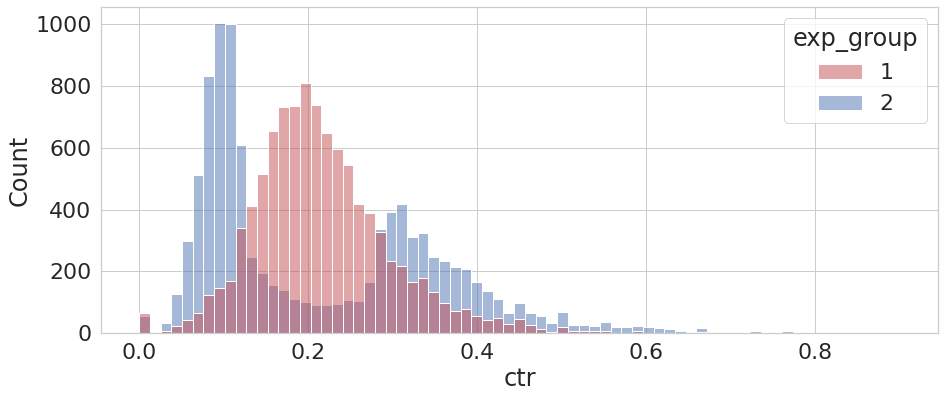

In [9]:
# визуализируем распределение CTR в 1 и 2 группах
sns.histplot(data = users_df, x = 'ctr', hue = 'exp_group', palette = ['r', 'b'])

Распределение в тестовой группе бимодально, а значит логично что условие на равенство дисперсий не выполяется.

<Axes: ylabel='Count'>

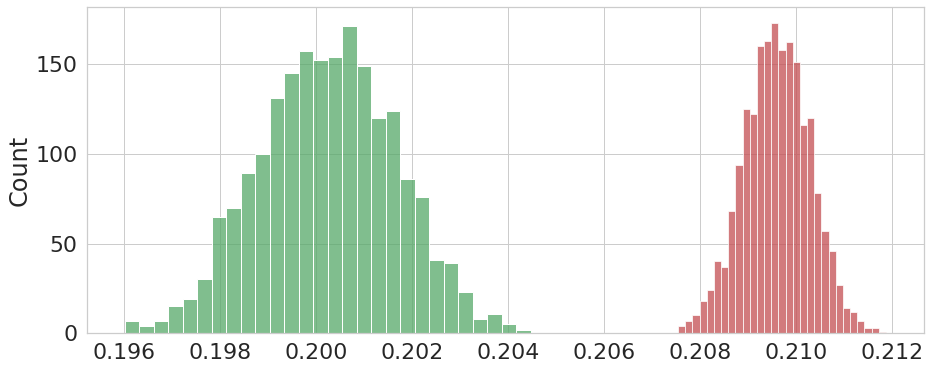

In [178]:
# попробуем проверить через Пуассоновский бутстреп
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

likes_test = users_df[users_df.exp_group == 2].likes.to_numpy()
views1_test = users_df[users_df.exp_group == 2].views.to_numpy()
likes2_control = users_df[users_df.exp_group == 1].likes.to_numpy()
views2_control = users_df[users_df.exp_group == 1].views.to_numpy()

ctr_test, ctr_control = bootstrap(likes_test, views1_test, likes2_control, views2_control)

sns.histplot(ctr_test, color = 'g')
sns.histplot(ctr_control, color = 'r')

Гистограммы даже непересекаются, а значит есть явное различие, причем в отрицательную сторону.

In [153]:
# функция расчета сглаженного CTR
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [155]:
# посчитаем слгаженный CTR в тесте и контроле
global_ctr_test = test.likes.sum()/test.views.sum()
global_ctr_control = control.likes.sum()/control.views.sum()

test1 = test.copy()
test1['smothed_ctr'] = test.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_test, 5), axis=1)

control1 = control.copy()
control1['smothed_ctr'] = control.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_control, 5), axis=1)

<Axes: xlabel='smothed_ctr', ylabel='Count'>

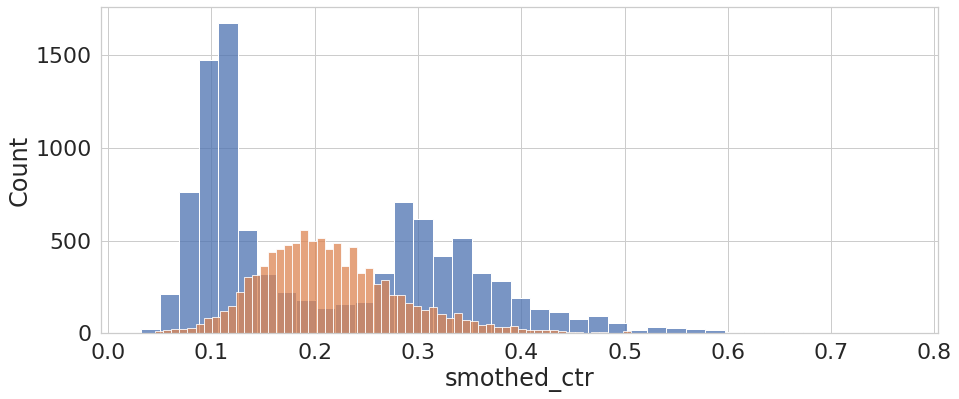

In [158]:
#распределение сглаженного CTR не сильно изменилось
sns.histplot(test1.smothed_ctr)
sns.histplot(control1.smothed_ctr)

In [159]:
#сравним сглаженные CTR t-тестом
stats.ttest_ind(test1.smothed_ctr, control1.smothed_ctr, equal_var=False)

Ttest_indResult(statistic=-1.9460491517027683, pvalue=0.05166679015318526)

T-Тест не видит различия, при этом получилось пограничное значение p value

In [160]:
#но условие на гомогенность дисперсийй по прежнему не выполняется
stats.levene(test1.smothed_ctr, control1.smothed_ctr, center='median')

LeveneResult(statistic=3120.7828985765664, pvalue=0.0)

In [161]:
#сделаем бакетное преобразование и посчитаем в каждом из бакетов CTR
q2 = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) >= toDate('2024-06-28') and toDate(time) <= toDate('2024-07-04') and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket = ph.read_clickhouse(q2, connection=connection)

<Axes: xlabel='bucket_ctr', ylabel='Count'>

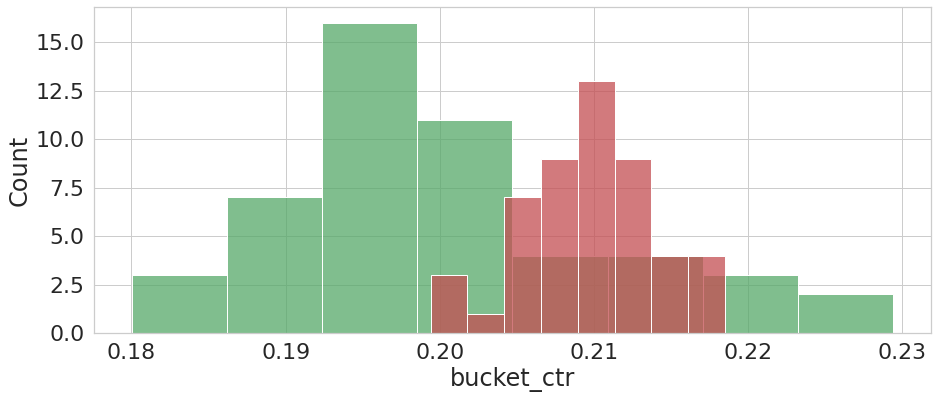

In [174]:
#посмотрим на бакетный CTR, "на глаз" кажется что контроле бакетный CTR выше
sns.histplot(df_bucket[df_bucket.exp_group == 2].bucket_ctr, color = 'g')
sns.histplot(df_bucket[df_bucket.exp_group == 1].bucket_ctr, color = 'r')

In [166]:
#дисперсии бакетного CTR по прежнему различаются
stats.levene(df_bucket[df_bucket.exp_group == 2].bucket_ctr, df_bucket[df_bucket.exp_group == 1].bucket_ctr, center='median')

LeveneResult(statistic=19.517795982806632, pvalue=2.5730021424382185e-05)

In [170]:
#тем не менее t-тест прокрасился
stats.ttest_ind(df_bucket[df_bucket.exp_group == 2].bucket_ctr, df_bucket[df_bucket.exp_group == 1].bucket_ctr, equal_var=False)

Ttest_indResult(statistic=-5.614819358149381, pvalue=4.592644937473873e-07)

In [171]:
# Манн-Уитни также видит различие
stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 2].bucket_ctr, df_bucket[df_bucket.exp_group == 1].bucket_ctr, alternative = 'two-sided')

MannwhitneyuResult(statistic=503.0, pvalue=2.6576427804010095e-07)

In [175]:
#посмотрим в какую сторону
A_gt_B = 0
n = 10000
for _ in range(n):
    A_gt_B+= df_bucket[df_bucket.exp_group == 2].bucket_ctr.sample().values[0] > df_bucket[df_bucket.exp_group == 1].bucket_ctr.sample().values[0]
    
print('В', f"{A_gt_B/n:.1%}", 'случаев bucket_ctr в тесте > чем в контроле')

В 19.8% случаев bucket_ctr в тесте > чем в контроле


Итого:
1. t-тест не прокрасился, но условие гомогенности дисперсий не выполнено.
2. Пуассоновский бутстреп видит отличие, причем в тестовой группе ухудшился ctr.
3. тест Манна-Уитни также прокрасился в отрицательную сторону
4. t-тест на сглаженном ctr не прокрасился (пограничное значение p value), при этом требование о гомогенности дисперсий не выполняется.
5. t-тест поверх бакетного преобразования видит различия, также условие гомогенности дисперсий не выполнено.
6. тест Манна-Уитни поверх бакетного преобразования  прокрасился в отрицательную сторону.

T-тесты не стоит применять в данном случае из-за того что дисперсии в группах сильно отличаются.
Поэтому стоит доверять непараметрике (бутстрепу и Манн-Уитни), которые показали отрицательный результат.
Сложно сказать почему в тестовой группе распределение CTR стало похоже на бимодальное. Возможно новый алгоритм рекомендаций постов на части пользователей показывается себя лучше, а на другой части хуже. Поскольку мы убедились, что система сплитования работает корректно, то это не должно быть связано с характеристиками пользователей. Возможно это связано с какими-то внешними факторами.

Резюмируя, я бы не стал выкатывать новый алгоритм рекомендации постов.